# Trends and Anomlaies in the Variables

### Explore my SSH, SST, Ekman transport (and wind stress data?)
- period of common data 01/01/1993 - 09/11/2021 -› almost 28 years
#### Maps
1. Slope of Trend at each grid cell
    - whole year (annual mean trend)
    - summer (seasonal mean trend)
2. Anomaly
    -  ref period: 1993 to 2012 (20 years), compared to 2013 to 2021 (8 years)
    -  whole year
    -  summer


In [1]:
## Notes

# why is my trend so small?? what is going on?? ... I mean I hardly have a trend... maybe this is just 
# what happens with really small values... I don't like it

# time period ... for SST and MTSS I should use the full preiod of data that I have ... would be a 
# waste not to

# I can extend my UI SST for the period that I have CoRTAD data for -> so instead of 0


In [14]:
## import packages
import xarray as xr
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
#import matplotlib.patches as mpatches
import matplotlib
import cartopy.crs as ccrs
#import glob
import os
import my_functions
import datetime
import statsmodels.api as sm
%matplotlib inline

In [41]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [59]:
## selct common period MTSS and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [93]:
## preprocessing steps

# calculate upwelling index from wind stress dataset -> use my upwelling function (from my_functions.py)
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm))

# add week and month
Ek = my_functions.add_week_and_month(Ek)
SST = my_functions.add_week_and_month(SST)
SSH = my_functions.add_week_and_month(SSH)

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default (adds weeks and months)
Ek_summer = my_functions.subset_summer(Ek)
SST_UI_summer = my_functions.subset_summer(UI_SST)
SST_summer = my_functions.subset_summer(SST)
SSH_summer = my_functions.subset_summer(SSH)

## Common Definitions 
(Anomaly reference and current period)

In [94]:
## Anomaly period
# same for Ek and SST (because I have 40 years of data)
# define the reference and current periods
# here: first twenty and last ten years of data (i.e. 1982-2001 and 2013-2022)
# first 20
reference = Ek.time.dt.isocalendar().year.min().values + 19 
# last 10
current = Ek.time.dt.isocalendar().year.max().values - 9 

## Anomaly periods for SSH 
# shorter so I am taking first and last 10 years of data
# here: first and last ten years of data (i.e. 1993-2002 and 2012-2021)
# first 10 -> first date assigned is 29/12/2012 becuase of the weekly averaging and assingning date to Tuesday
reference_SSH = SSH.time.dt.isocalendar().year.min().values + 10
# last 10 -> minus nine years because the last year is already fully included 01/2021 - 12/2021
current_SSH = SSH.time.dt.isocalendar().year.max().values - 9 

## Functions

In [133]:
# plot monthly means
def plot_monthly_means(DS, DS_month, Ek = False, title = 'Title', cbar_label = 'lable', cmap = 'viridis', vmin = -1, vmax = 1, save = False, save_fig_as = 'figure'):
    xsize = 4 # is actually the number of rows
    ysize = 3 # is the number of collumns
    
    months = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']


    fig, axs = plt.subplots(xsize, ysize, figsize = (12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    i = 0
    for x in np.arange(0, xsize):
        for y in np.arange(0, ysize):
            
            ax = axs[x, y]
            
            ax.set_extent([-19, -5.5, 45, 36])
            ax.coastlines()
            gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
            gls.top_labels = False 
            gls.right_labels = False

            if Ek == False: 
                cp = DS.where(DS_month == months[i], drop = True).mean(dim = 'time').plot(ax = axs[x, y], transform = ccrs.PlateCarree(), 
                               add_colorbar = False, vmin = vmin, vmax = vmax, extend = 'both', cmap = cmap)
            if Ek == True:
                col = np.hypot(DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time'), 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time'))
                im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time'), 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time'), 
                               col, angles='xy', scale_units='xy', scale = 2, clim = [0,1]) 
                qk = ax.quiverkey(im, -0.1, 1.1, 1, r'1 $\frac{m^3}{s \ m}$', labelpos='E')
                
            ax.set_title(f'Mean {title} {months[i]}')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
    
            i = i + 1
    
    # adjust spacing around subplots (because fig.tight_layout() doesn't work with the method I use to add the colorbar
    plt.subplots_adjust(bottom=0.5, right=1.1, top=1.3)
    
    fig.subplots_adjust(bottom = 0.25)
    cbar_ax = fig.add_axes([0.25, 0.18, 0.7, 0.03])
    if Ek == False:
        fig.colorbar(cp, cax=cbar_ax, orientation = 'horizontal', label = cbar_label)
    if Ek == True: 
        fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal', label = r'Ekamn transport [$\frac{m^3}{s \ m}$]');
        

    if save == True:
        fig.savefig(f'Iberian_Coast_Upwelling/Figures/{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

In [96]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label'):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.title(title)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);


In [97]:
## plot anomaly

def plot_anomaly_map(DS, refernce, current, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label'):
    DS_reference = DS.where(SSH.time.dt.isocalendar().year <= reference, drop = True).mean(dim = 'time')
    DS_current = DS.where(SSH.time.dt.isocalendar().year >= current, drop = True).mean(dim = 'time')
    DS_anomaly = DS_current - DS_reference

    plot_map(DS_anomaly, title = title, cmap = cmap, vmin = vmin, vmax = vmax, cbar_label = cbar_label)

    #return DS_anomaly, DS_ref, DS_cur

## Ekman

### Ek Mean

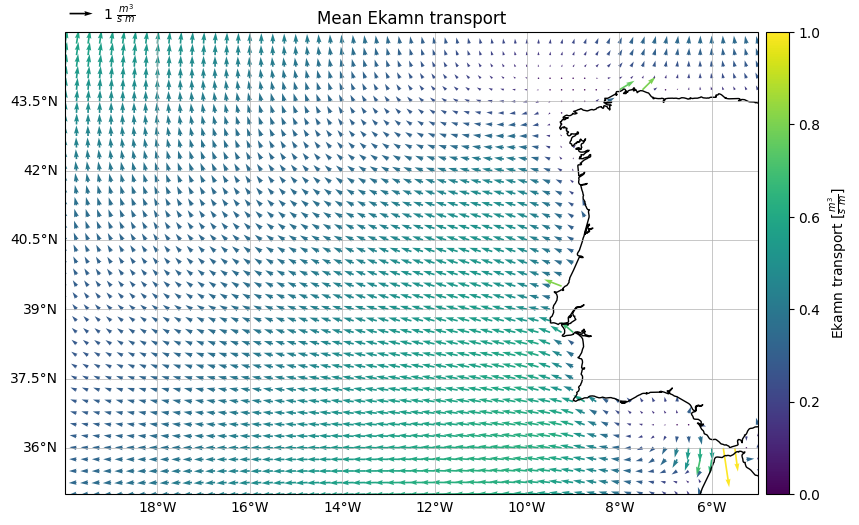

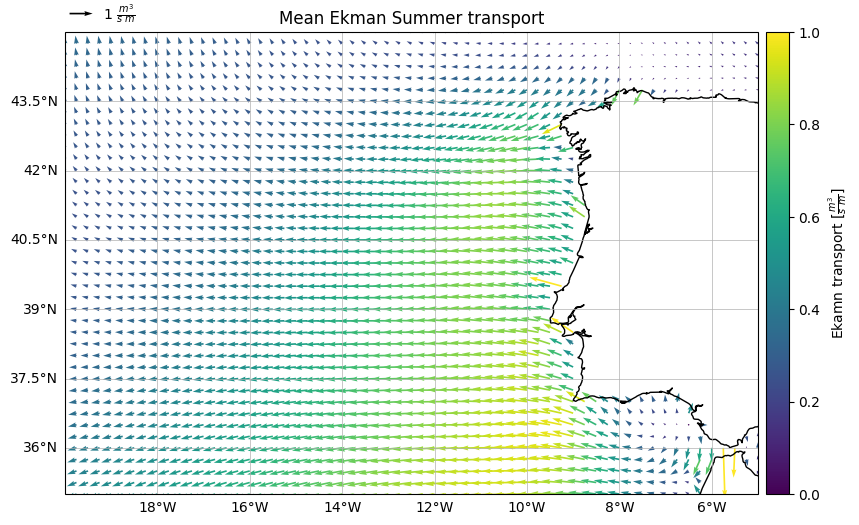

In [118]:
for DS, title in zip([Ek, Ek_summer], ['Mean Ekamn transport', 'Mean Ekman Summer transport']):
    # plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-20, -5, 45, 35])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False  
    
    ax.set_title(title)
    col = np.hypot(DS.ek_trans_u.mean(dim = 'time'), DS.ek_trans_v.mean(dim = 'time'))
    im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u.mean(dim = 'time'), DS.ek_trans_v.mean(dim = 'time'), 
                             col, angles='xy', scale_units='xy', scale = 2, clim = [0,1]) 
    qk = ax.quiverkey(im, 0.04, 1.04, 1, r'1 $\frac{m^3}{s \ m}$', labelpos='E')
    plt.colorbar(im, label = r'Ekamn transport [$\frac{m^3}{s \ m}$]', pad = 0.01, fraction = 0.046);


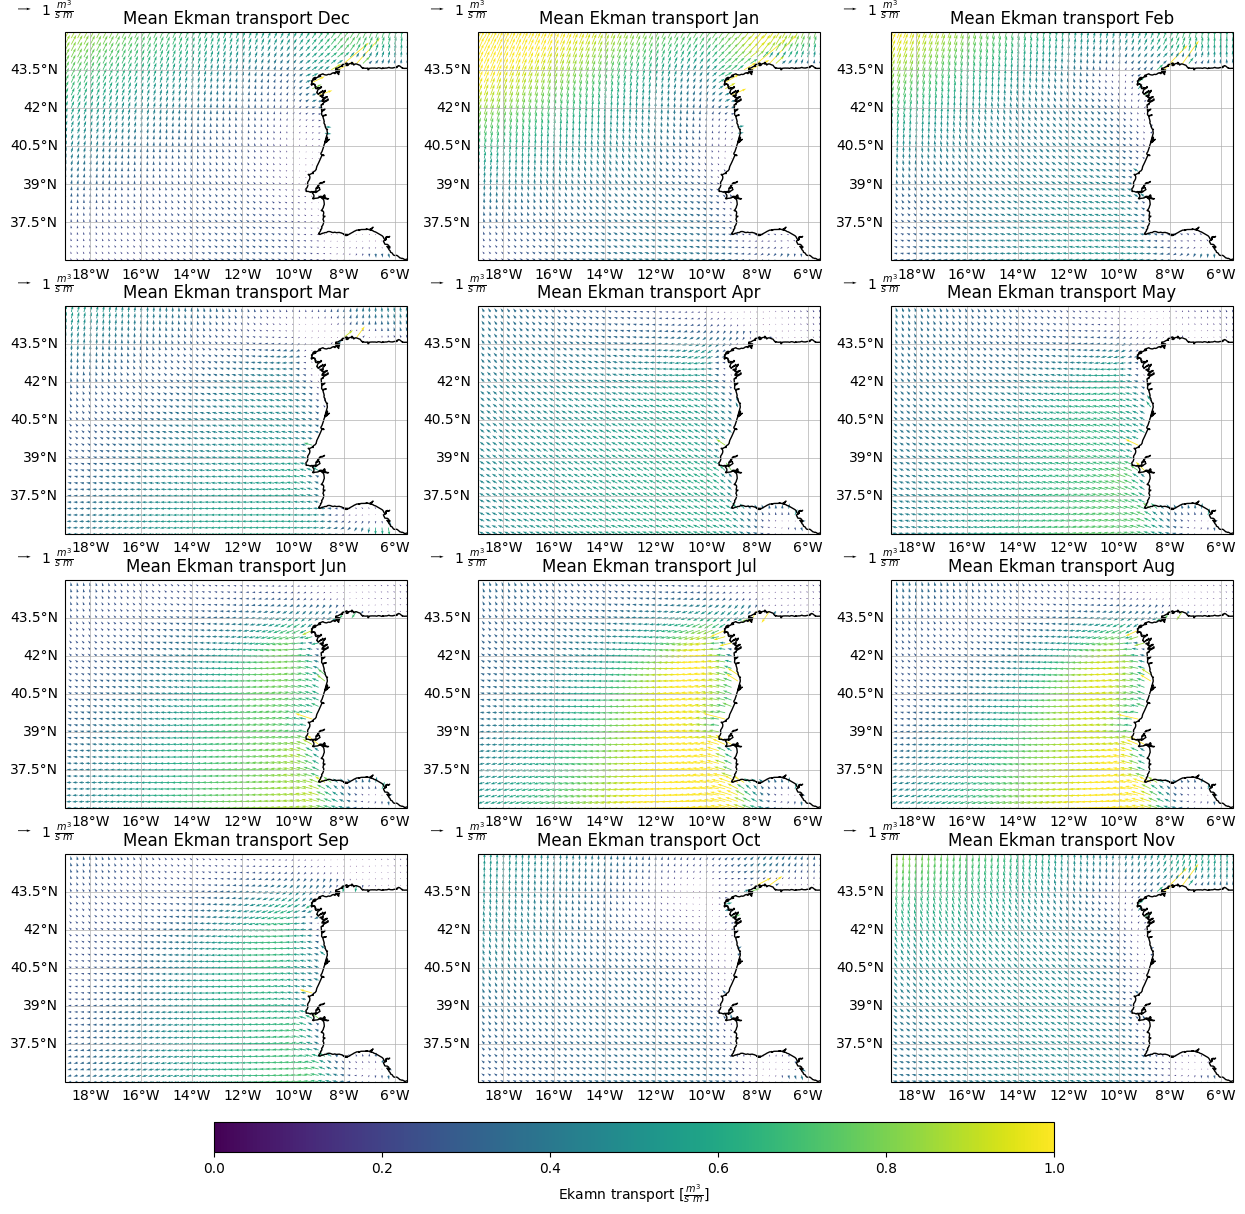

In [134]:
plot_monthly_means(Ek, Ek.month, Ek = True, title = 'Ekman transport')

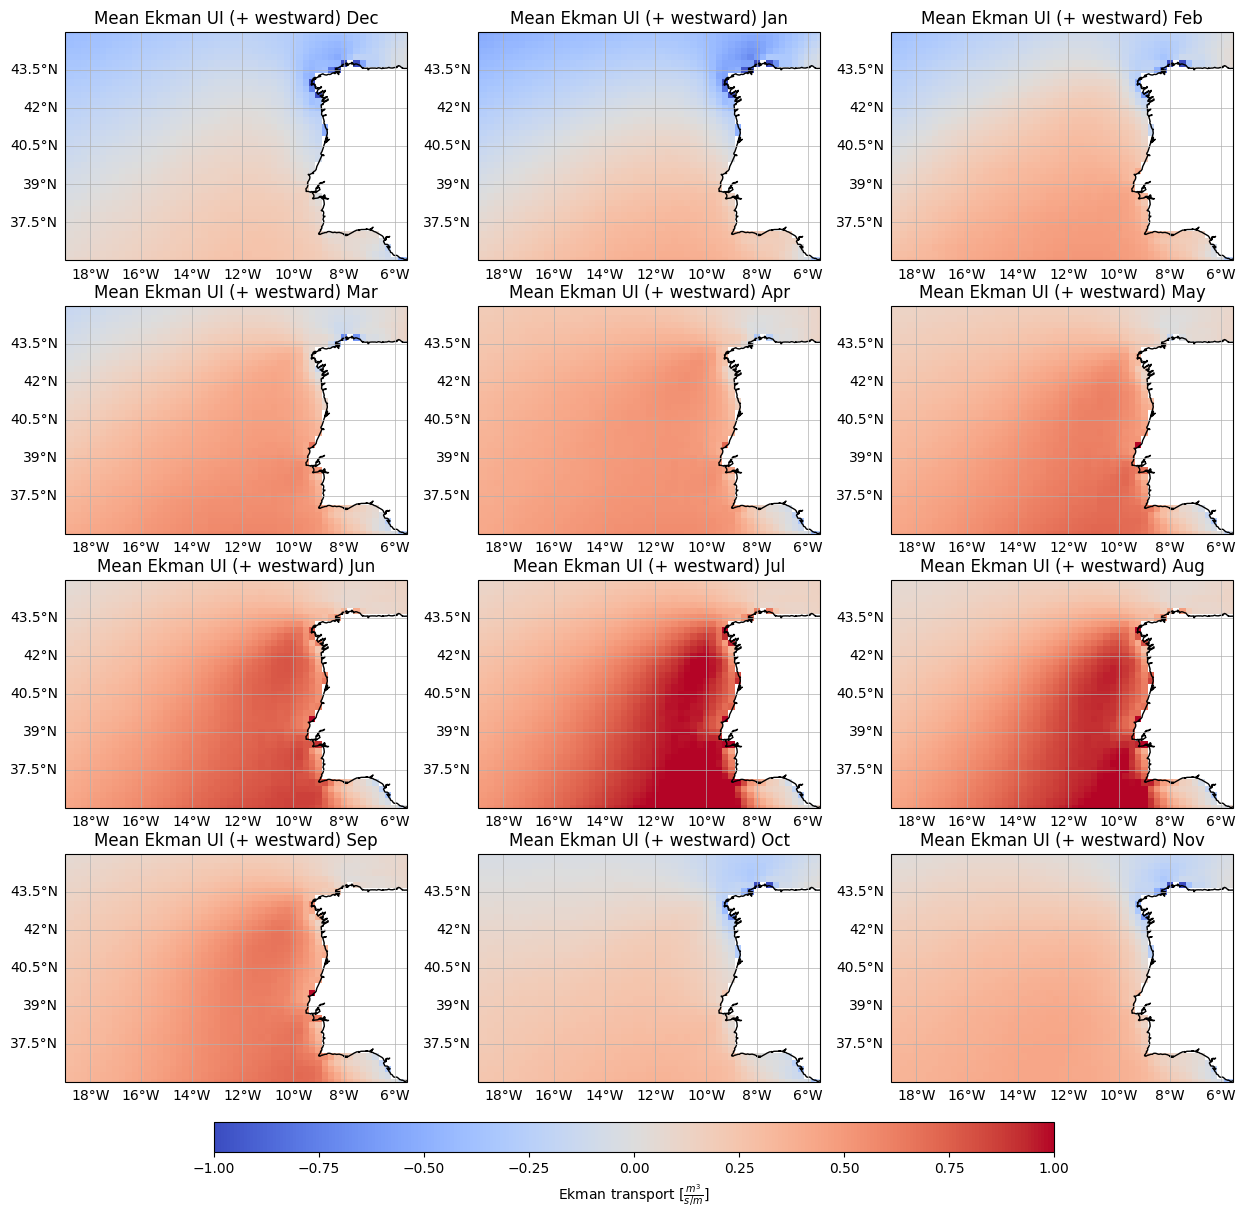

In [135]:
# plot only the westward Ekman transport
plot_monthly_means(Ek.UI, Ek.month, title = 'Ekman UI (+ westward)', cbar_label = r'Ekman transport [$\frac{m^3}{s / m}$]',
                   cmap = 'coolwarm', vmin = -1, vmax = 1)

### UI EK Trend

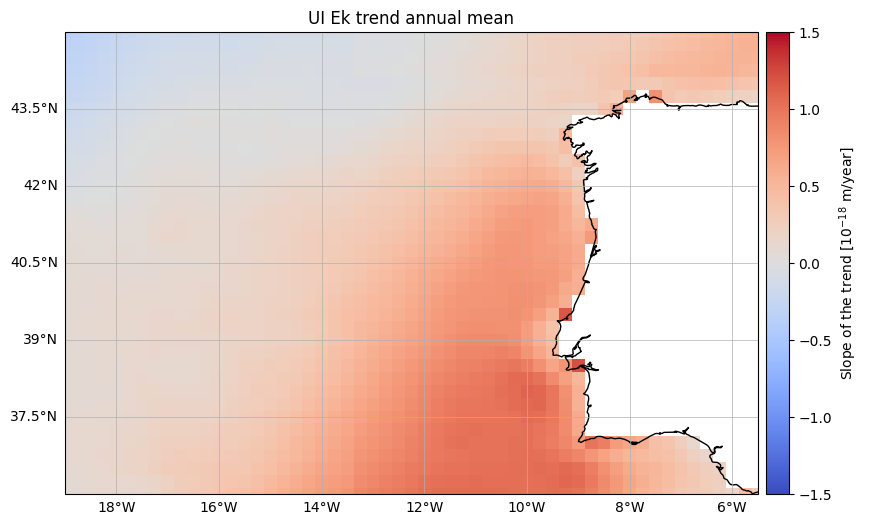

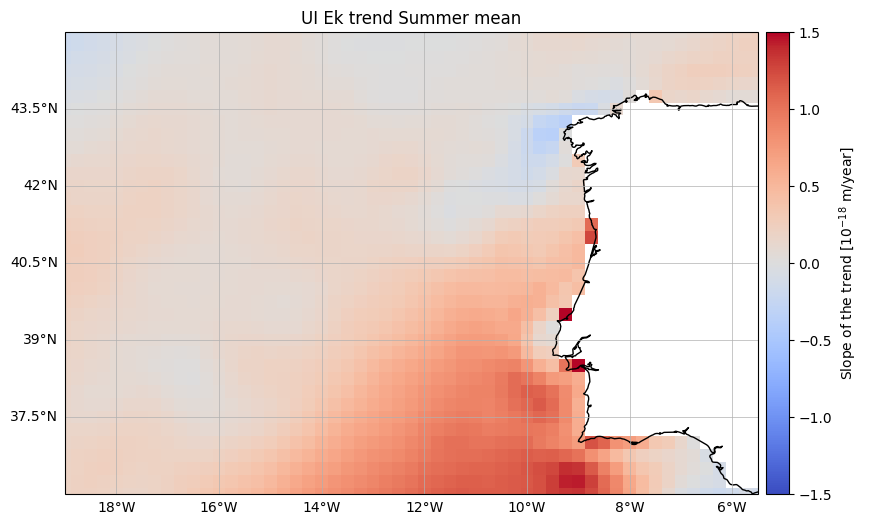

In [64]:
for DS, title in zip([Ek.UI, Ek_summer.UI], ['UI Ek trend annual mean', 'UI Ek trend Summer mean']):
    DS_annual = DS.resample(time = 'YE').mean() * 10e18 # ato
    result = DS_annual.polyfit(dim = 'time', deg = 1)
    
    plot_map(result.polyfit_coefficients.sel(degree = 1), title = title, 
             vmin = -1.5, vmax = 1.5, cbar_label = r'Slope of the trend [$10^{-18}$ m/year]')

### UI Ek Anomaly

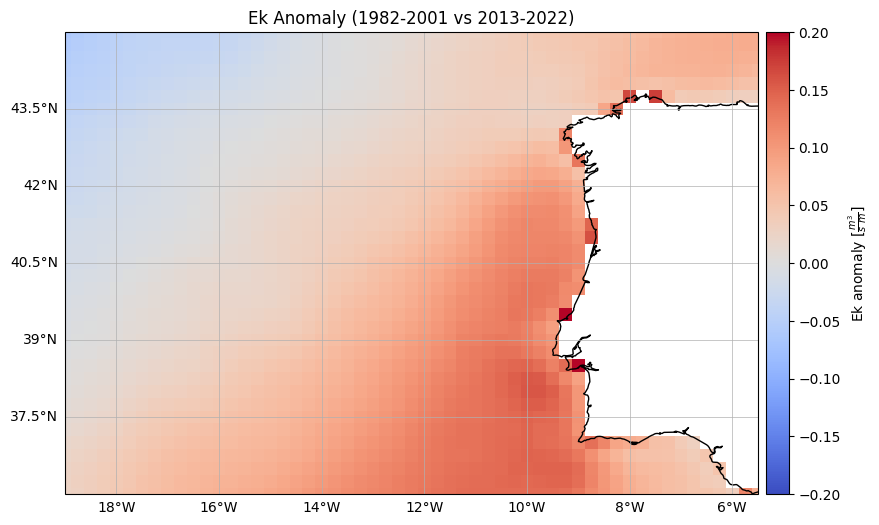

In [65]:
plot_anomaly_map(Ek.UI, reference, current, title = 'Ek Anomaly (1982-2001 vs 2013-2022)', 
         vmin = -0.2, vmax = 0.2, cbar_label = r'Ek anomaly [$\frac{m^3}{s \ m}$]')

## SST

### SST Mean

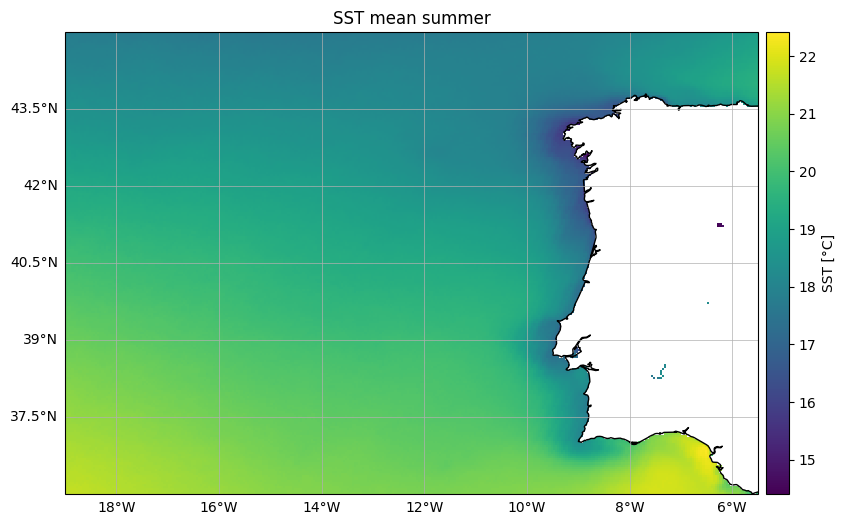

In [9]:
## mean summer SST
plot_map(SST_summer.SST.mean(dim = 'time'), title = 'SST mean summer',
        cmap = 'viridis', cbar_label = 'SST [°C]')

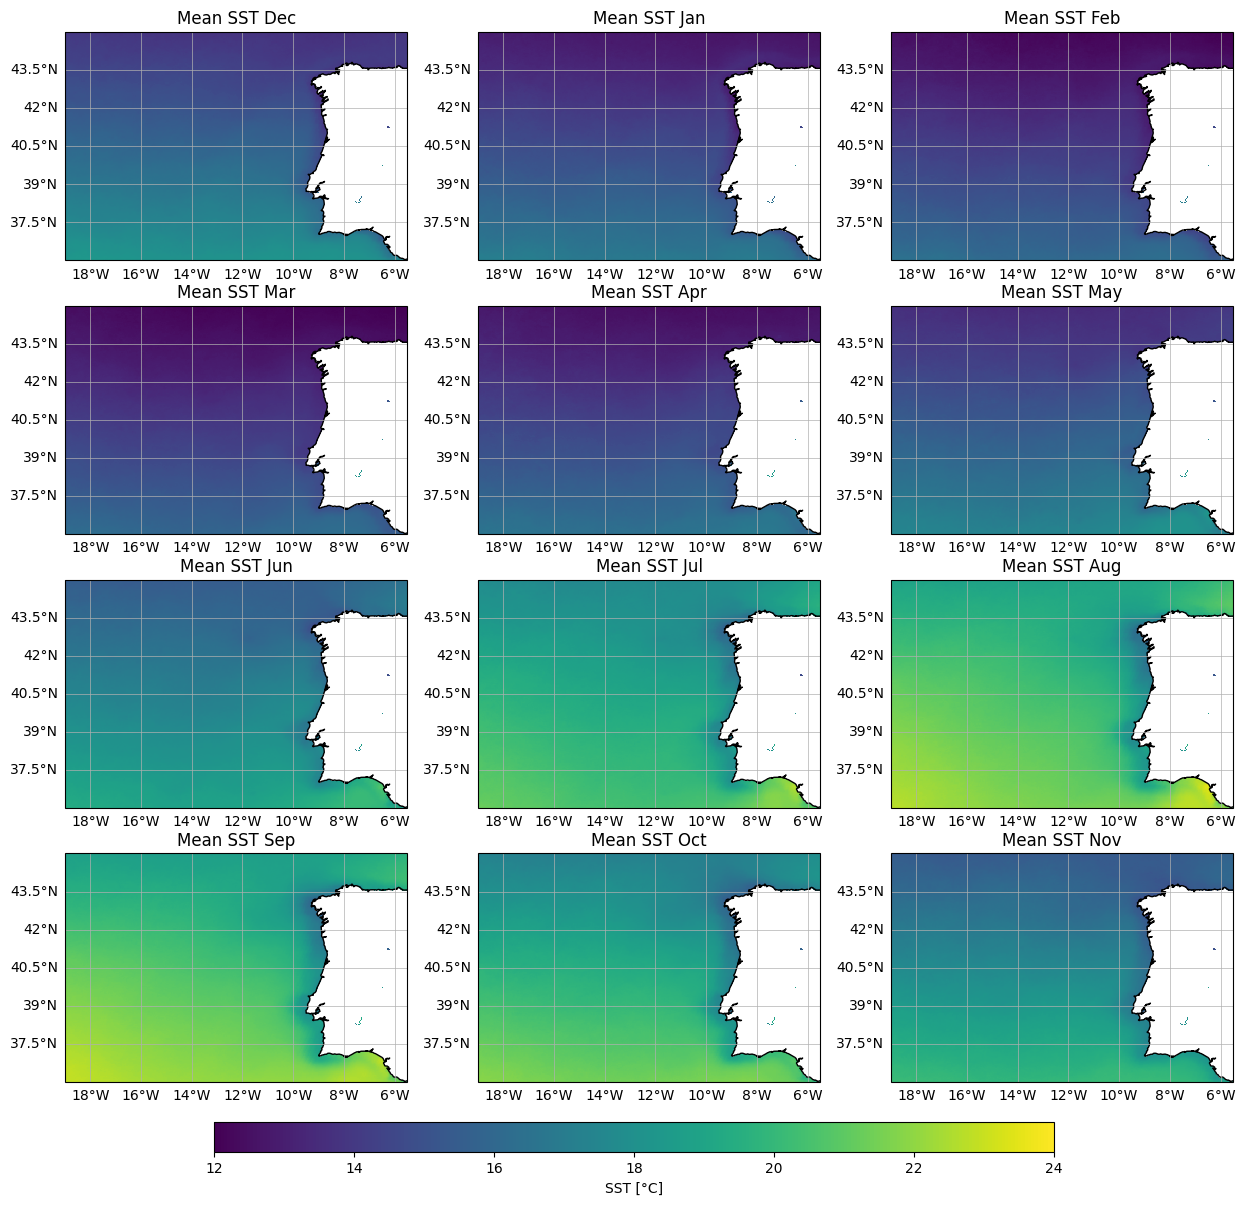

In [136]:
plot_monthly_means(SST.SST, SST.month, title = 'SST', cbar_label = 'SST [°C]', vmin = 12, vmax = 24)

### SST Trend

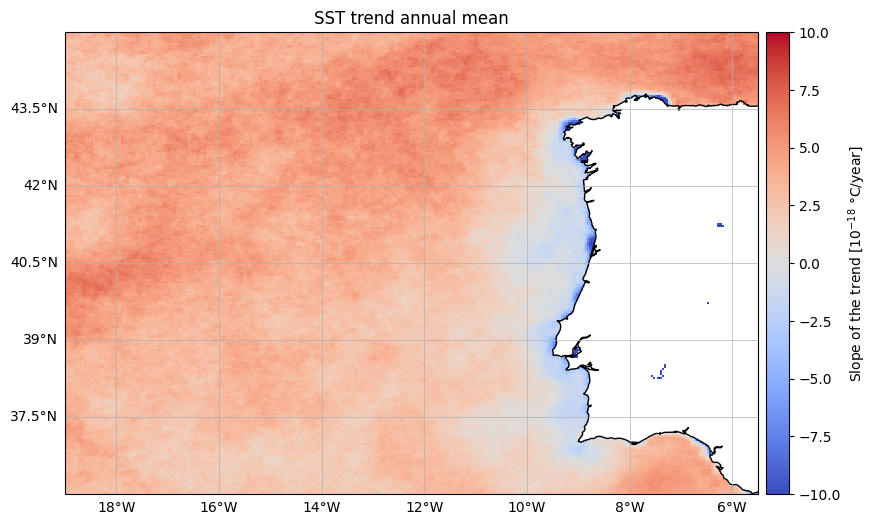

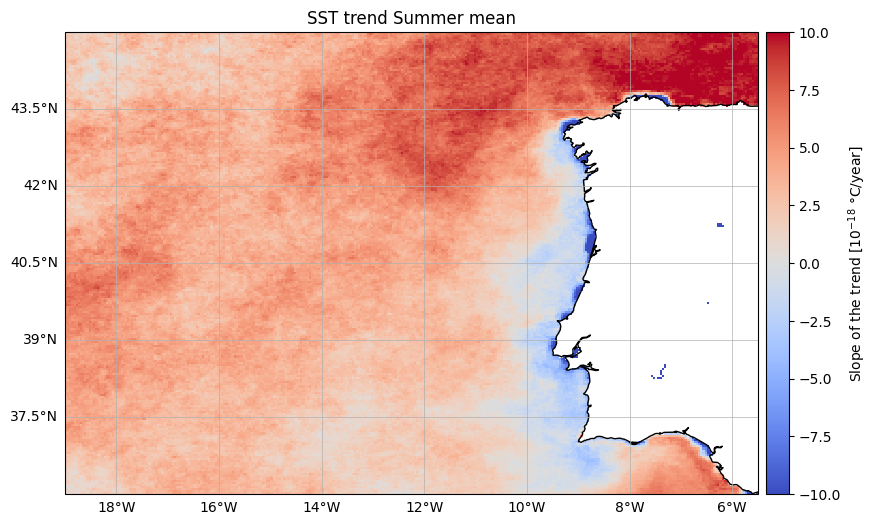

In [10]:
for DS, title in zip([SST.SST, SST_summer.SST], ['SST trend annual mean', 'SST trend Summer mean']):
    DS_annual = DS.resample(time = 'YE').mean() * 10e18 # ato
    result = DS_annual.polyfit(dim = "time", deg = 1)

    plot_map(result.polyfit_coefficients.sel(degree=1), title = title,
             vmin = -10, vmax = 10, cbar_label = r'Slope of the trend [$10^{-18}$ °C/year]')

### SST Anomaly

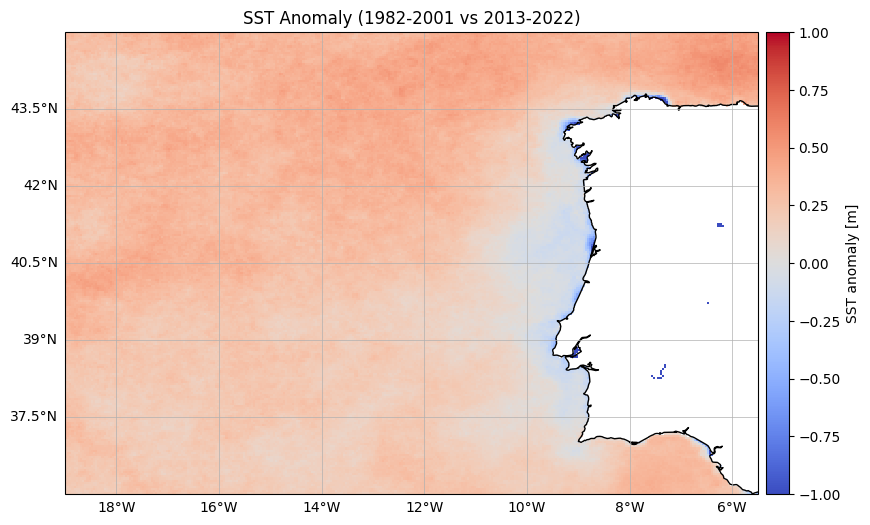

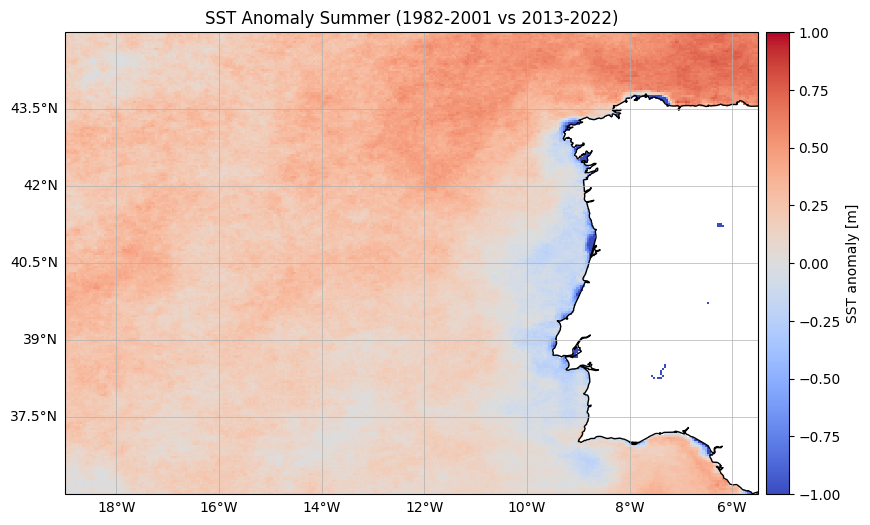

In [132]:
plot_anomaly_map(SST.SST, reference, current, title = 'SST Anomaly (1982-2001 vs 2013-2022)', 
         vmin = -1, vmax = 1, cbar_label = 'SST anomaly [m]')
plot_anomaly_map(SST_summer.SST, reference, current, title = 'SST Anomaly Summer (1982-2001 vs 2013-2022)', 
         vmin = -1, vmax = 1, cbar_label = 'SST anomaly [m]')

## SSH

### SSH mean

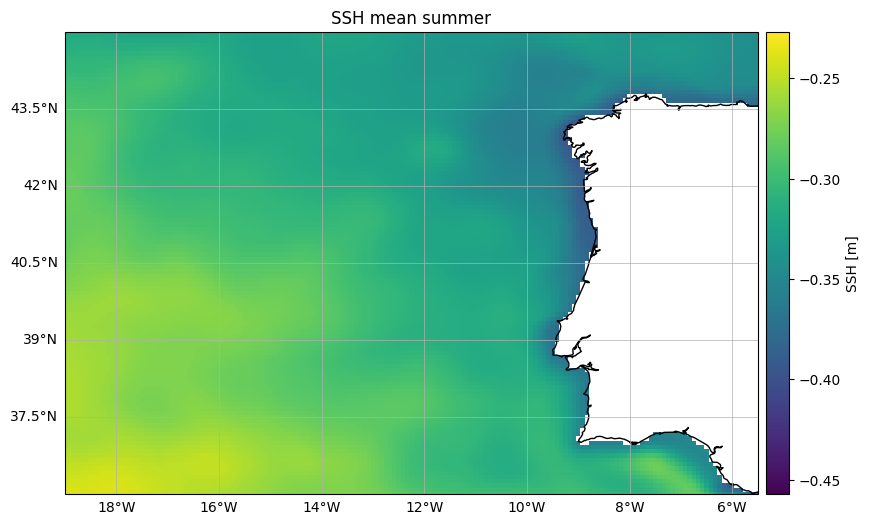

In [21]:
## mean summer SSH
plot_map(SSH_summer.zos.mean(dim = 'time'), title = 'SSH mean summer',
        cmap = 'viridis', cbar_label = 'SSH [m]')

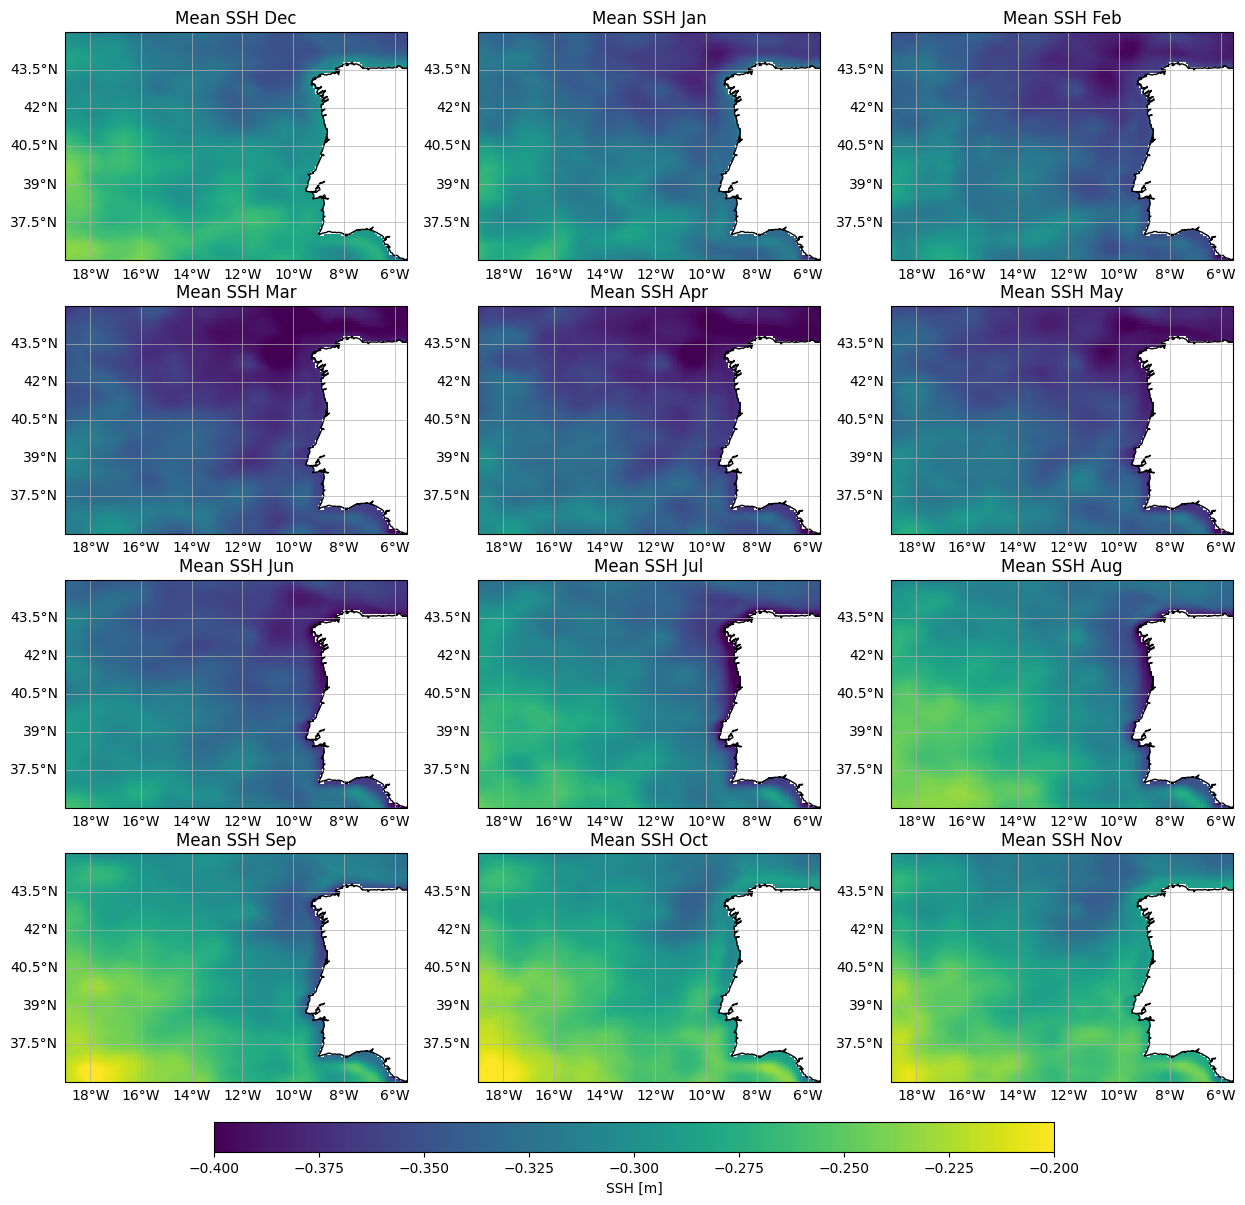

In [147]:
plot_monthly_means(SSH.zos, SST.month, title = 'SSH', cbar_label = 'SSH [m]', vmin = -0.4, vmax = -0.2)

### SSH Trend

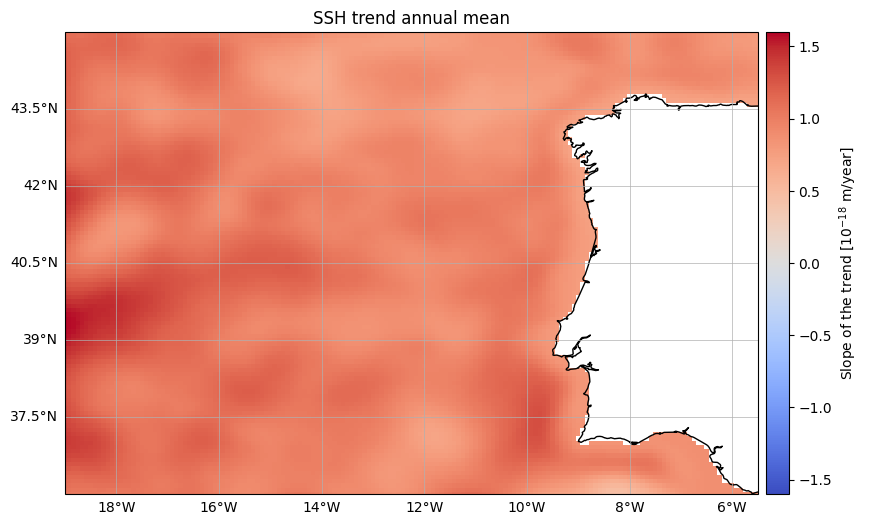

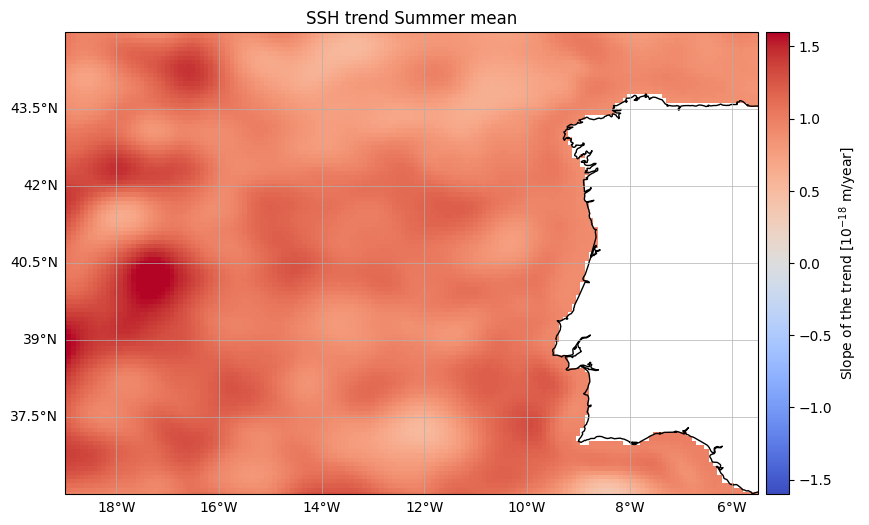

In [229]:
for DS, title in zip([SSH.zos, SSH_summer.zos], ['SSH trend annual mean', 'SSH trend Summer mean']):
    DS_annual = DS.resample(time = 'YE').mean() * 10e18 # ato
    result = DS_annual.polyfit(dim = "time", deg = 1)
    
    plot_map(result.polyfit_coefficients.sel(degree=1), title = title, 
             vmin = -1.6, vmax = 1.6, cbar_label = r'Slope of the trend [$10^{-18}$ m/year]')

### SSH Anomaly

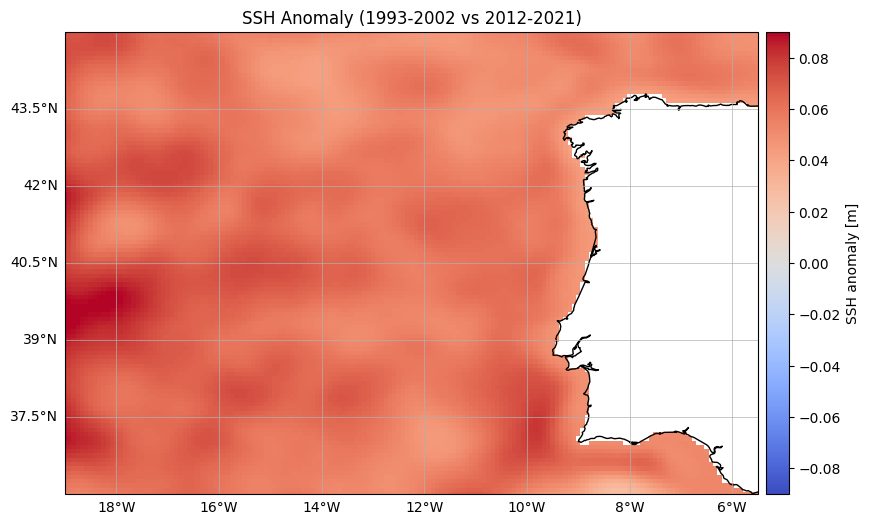

In [32]:
plot_anomaly_map(SSH.zos, reference_SSH, current_SSH, title = 'SSH Anomaly (1993-2002 vs 2012-2021)', 
         vmin = -0.09, vmax = 0.09, cbar_label = 'SSH anomaly [m]')

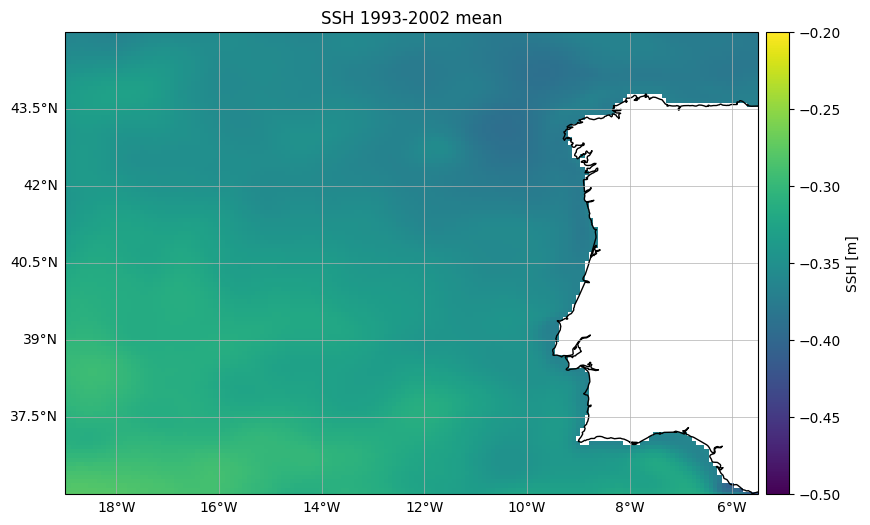

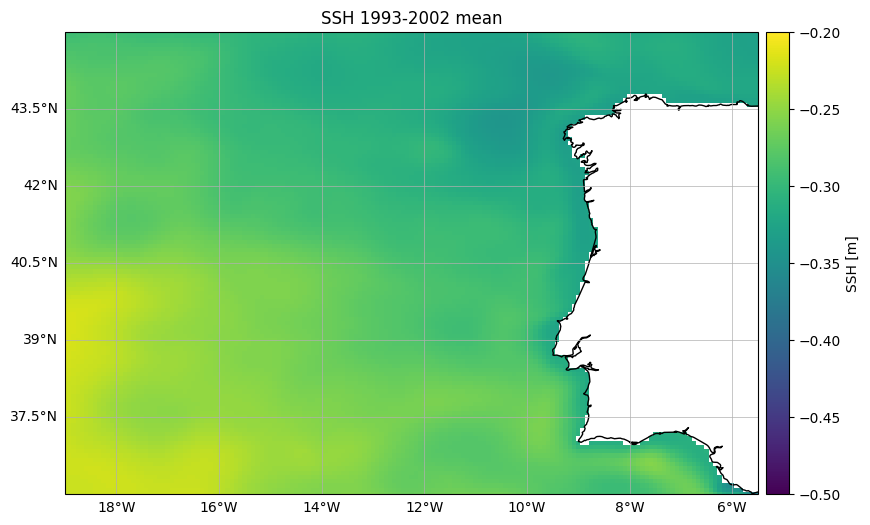

In [33]:
# first 10 years 1993-2002 (including)
SSH_ref = SSH.zos.where(SSH.time.dt.isocalendar().year <= reference_SSH, drop = True).mean(dim = 'time') 
# ref last 8 years 2012-2021 (including)
SSH_cur = SSH.zos.where(SSH.time.dt.isocalendar().year >= current_SSH, drop = True).mean(dim = 'time')  
# plot
plot_map(SSH_ref, title = 'SSH 1993-2002 mean', cmap = 'viridis', 
         vmin = -0.5, vmax = -0.2, cbar_label = 'SSH [m]')
plot_map(SSH_cur, title = 'SSH 1993-2002 mean', cmap = 'viridis',
         vmin = -0.5, vmax = -0.2, cbar_label = 'SSH [m]')